Only reading in one email for now

In [64]:
emailDir = "./maildir/maildir"
enroncsv = "../experiments/enron.csv"
metadataHeaders = '../experiments/metadataHeaders.csv'
spamWords = '../experiments/spamWords.txt'

In [65]:
import pandas as pd

columns = pd.read_csv(metadataHeaders, sep=',').columns.tolist()
columns

['Filename',
 'Person',
 'Directory',
 'Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Cc',
 'Time',
 'Attendees',
 'Re',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'Bcc',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [66]:
df = pd.read_csv(enroncsv, names=columns, sep='|', low_memory=False)

print("-- DONE --")

-- DONE --


Lets query for a mail that does not have `Message-ID` with `.JavaMail.evans@thyme`

In [67]:
result = df[pd.notnull(df['Message-ID'])]

result = result.loc[~result['Message-ID'].str.contains('.JavaMail.evans@thyme')]
result

Empty DataFrame
Columns: [Filename, Person, Directory, Message-ID, Date, From, To, Subject, Cc, Time, Attendees, Re, Mime-Version, Content-Type, Content-Transfer-Encoding, Bcc, X-From, X-To, X-cc, X-bcc, X-Folder, X-Origin, X-FileName]
Index: []

[0 rows x 23 columns]

In [68]:
result = df[pd.notnull(df['Subject'])]

result = result.loc[result['Subject'].str.contains('Porn')]
len(result)

25

No results so the server `.JavaMail.evans@thyme` is not helpfull

Lets count the number of non null fields per header and make it a percentage over the total number of parsable emials

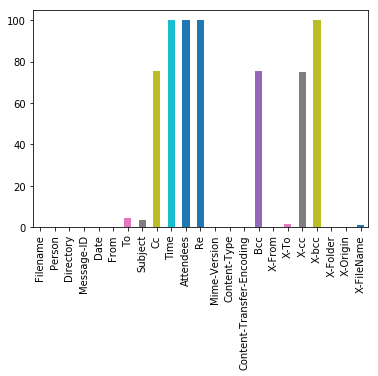

Filename                      0.000000
Person                        0.000000
Directory                     0.000000
Message-ID                    0.000387
Date                          0.000387
From                          0.000387
To                            4.222880
Subject                       3.713189
Cc                           75.279489
Time                         99.999807
Attendees                    99.994201
Re                           99.998840
Mime-Version                  0.011597
Content-Type                  0.011597
Content-Transfer-Encoding     0.010631
Bcc                          75.284322
X-From                        0.011404
X-To                          1.770680
X-cc                         75.084079
X-bcc                        99.959410
X-Folder                      0.012370
X-Origin                      0.006958
X-FileName                    0.820493
dtype: float64

In [69]:
import matplotlib.pyplot as plt

numberOfRows = len(df.index)
missingData = (numberOfRows - df.count()) / numberOfRows * 100
plot = missingData.plot(kind='bar')

plt.show()
missingData

How many people flolders don't match their X-origin

In [70]:
len(df.loc[df['Person'] != df['X-Origin'].str.lower()])

35496

How many different `Content-Type`'s are in the dataset

In [71]:
df['Content-Type'].unique()

array([nan, 'text/plain; charset="us-ascii"',
       'text/plain; charset="ANSI_X3.4-1968"'], dtype=object)

How many different `Content-Transfer-Encoding`'s are in the dataset

In [72]:
df['Content-Transfer-Encoding'].unique()

array([nan, '7bit', 'quoted-printable', 'base64',
       '\\JSKILLIN (Non-Privileged)\\Deleted Items', '\\jskillin\\Inbox',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Deleted Items',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Inbox',
       'EID: <24606> ERe: <0>'], dtype=object)

How many different `Mime-Version`'s are in the dataset

In [73]:
df['Mime-Version'].unique()

array([nan,  1.])

Lets remove those colums that are almost never filled in or that are irrelevent

In [74]:
removableColumns = ['Time', 'Attendees', 'Bcc', 'X-bcc', 'X-cc', 'X-Origin']

import csv
with open('removableColumns.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(removableColumns)

df.drop(removableColumns, axis=1)

print('-- DONE --')

-- DONE --


In [75]:
listOfEmailsForBagOfWords = df.loc[df['Directory'].str.contains('inbox')]

print('-- DONE --')

-- DONE --


In [76]:
wordsPerEmail = df[pd.notnull(df['Subject'])]
nonSpamSubjects = wordsPerEmail['Subject']
wordsPerEmail = nonSpamSubjects.str.split(' ')
len(wordsPerEmail)

498161

In [77]:
def addToBagOfWords(dictionary, arr):
    for word in arr:
        word = word.lower()

        if '/' in word:
            continue
        if '\\' in word:
            continue
        if '_' in word:
            continue
        if '-' in word:
            continue
        if ':' in word:
            continue
        if '@' in word:
            continue
        if '#' in word:
            continue
        if '$' in word:
            word = '$'

        word = word.replace('.', '')
        word = word.replace(')', '')
        word = word.replace('(', '')
        word = word.replace('&', '')
        word = word.replace('\'', '')
        word = word.replace('\"', '')
        word = word.replace(',', '')
        word = word.replace('[', '')
        word = word.replace(']', '')
        word = word.replace('{', '')
        word = word.replace('}', '')
        word = word.replace(';', '')

        if word == '':
            continue

        if word in dictionary:
            dictionary[word] = dictionary[word] + 1
        else:
            dictionary[word] = 1
            
    return dictionary

In [78]:
def addToDictionary(dictionary, arr):
    for index, subject in arr.iteritems():
        dictionary = addToBagOfWords(dictionary, subject)
                
    return dictionary

In [79]:
dictionary = {}

dictionary = addToDictionary(dictionary, wordsPerEmail)
        
len(dictionary)

39576

In [80]:
spamSubjects = pd.read_csv(spamWords, names=['Subject'], sep=',')
len(spamSubjects)

249

In [81]:
wordsPerEmail = spamSubjects['Subject'].str.split(' ')

dictionary = addToDictionary(dictionary, wordsPerEmail)
        
len(dictionary)

39606

In [82]:
dictionaryList = []
for key in dictionary:
    dictionaryList.append([key, dictionary[key]])
    
dictionaryList = pd.DataFrame(dictionaryList, columns=["Word", "Occurances"])
len(dictionaryList)

39606

In [83]:
dictionaryList = dictionaryList.loc[dictionaryList['Occurances'] > 30].reset_index(drop=True)
len(dictionaryList)

5559

In [101]:
import matplotlib.pyplot as plt
import numpy as np

training = []

trainingPos = df[pd.notnull(df['Subject'])]
trainingPos = trainingPos.sample(750)
trainingPos = trainingPos['Subject']

trainingPosSplit = trainingPos.str.split(' ')

for index, subject in trainingPosSplit.iteritems():
    posBagOfWords = {}
    posBagOfWords = addToBagOfWords(posBagOfWords, subject)
    
    listOfIn = []
    for key in posBagOfWords:
        listOfIn.append(key)
    
    inputBag = dictionaryList['Word'].isin(listOfIn).values.tolist()
    
    training.append([np.array(inputBag), np.array([0])])
    
trainingNeg = spamSubjects.sample(len(spamSubjects))
trainingNeg = trainingNeg['Subject']

trainingNegSplit = trainingNeg.str.split(' ')

for index, subject in trainingNegSplit.iteritems():
    negBagOfWords = {}
    negBagOfWords = addToBagOfWords(negBagOfWords, subject)
    
    listOfIn = []
    for key in negBagOfWords:
        listOfIn.append(key)
    
    inputBag = dictionaryList['Word'].isin(listOfIn).values.tolist()
    
    training.append([np.array(inputBag), np.array([1])])

training = np.array(training)
np.random.shuffle(training)

len(training)

999

In [102]:
from mlpy.dataSet.dataSetTool import DataSetTool
from mlpy.numberGenerator.bounds import Bounds
from mlpy.neuralNetwork.feedForwardNeuralNetwork import NeuralNetwork
from mlpy.neuralNetwork.structure.layer import Layer

l_rate = 0.001
bounds = Bounds(-2, 2)

inputLayer = Layer(bounds, size = len(training[0][0]), prev = None, l_rate = l_rate, bias = True, label = "Input layer")
hiddenLayer = Layer(bounds, size = 100, prev = inputLayer, l_rate = l_rate, bias = True, label = "Hidden layer")
outputLayer = Layer(bounds, size = len(training[0][1]), prev = hiddenLayer, l_rate = l_rate, bias = False, label = "Output layer")

fnn = NeuralNetwork()
fnn.appendLayer(inputLayer)
fnn.appendLayer(hiddenLayer)
fnn.appendLayer(outputLayer)

group_training = np.array([input[0] for input in training])
group_target = np.array([output[1] for output in training])

errors = []

In [ ]:
print("Staring")
for i in range(8000):
    mod = i % len(training)
    in_out = training[mod]
    result = fnn.fire(group_training)
    i_error = fnn.backPropagation(group_target)
    
    if i % 100 == 0:
        print(i_error.mean())
    
print("-- DONE --")

Staring
-0.5080940492500625
0.13343290149653778
0.08622054671251987
0.020629054289933675
0.016344863617097614
0.0009073894356720299
0.0007550796828837132
0.012952845928309541


In [96]:
testing = []

trainingPos = df[pd.notnull(df['Subject'])]
trainingPos = trainingPos.sample(250)
trainingPos = trainingPos['Subject']

trainingPosSplit = trainingPos.str.split(' ')

for index, subject in trainingPosSplit.iteritems():
    posBagOfWords = {}
    posBagOfWords = addToBagOfWords(posBagOfWords, subject)
    
    listOfIn = []
    for key in posBagOfWords:
        listOfIn.append(key)
    
    inputBag = dictionaryList['Word'].isin(listOfIn).values.tolist()
    
    testing.append([np.array(inputBag), np.array([0])])
    
trainingNeg = spamSubjects.sample(len(spamSubjects))
trainingNeg = trainingNeg['Subject']

trainingNegSplit = trainingNeg.str.split(' ')

for index, subject in trainingNegSplit.iteritems():
    negBagOfWords = {}
    negBagOfWords = addToBagOfWords(negBagOfWords, subject)
    
    listOfIn = []
    for key in negBagOfWords:
        listOfIn.append(key)
    
    inputBag = dictionaryList['Word'].isin(listOfIn).values.tolist()
    
    testing.append([np.array(inputBag), np.array([1])])

testing = np.array(testing)
np.random.shuffle(testing)

len(testing)

499

In [97]:
correct = 0
spamCorrect = 0
nonSpamCorrect = 0
for i in range(len(testing)):
    in_out = testing[i]
    result = fnn.fire(np.array([in_out[0]]))
    
    target = in_out[1][0]
    result = np.round(result[0][0])

    if result == target:
        correct += 1
        if target == 1:
            spamCorrect += 1
        else:
            nonSpamCorrect += 1
        
        
print("classification accuracy: ", correct / len(testing))
print("Non spam classification accuracy: ", nonSpamCorrect / 250)
print("Spam classification accuracy: ", spamCorrect / len(spamSubjects))

classification accuracy:  0.751503006012024
Non spam classification accuracy:  0.62
Spam classification accuracy:  0.8835341365461847
